In [1]:
%matplotlib notebook

from IPython.display import Image
from simplify.face_lattice import FaceLattice
from simplify.simplify import *
from simplify.plot import *
from simplify.homothety import *
from islpy import *

<IPython.core.display.Javascript object>


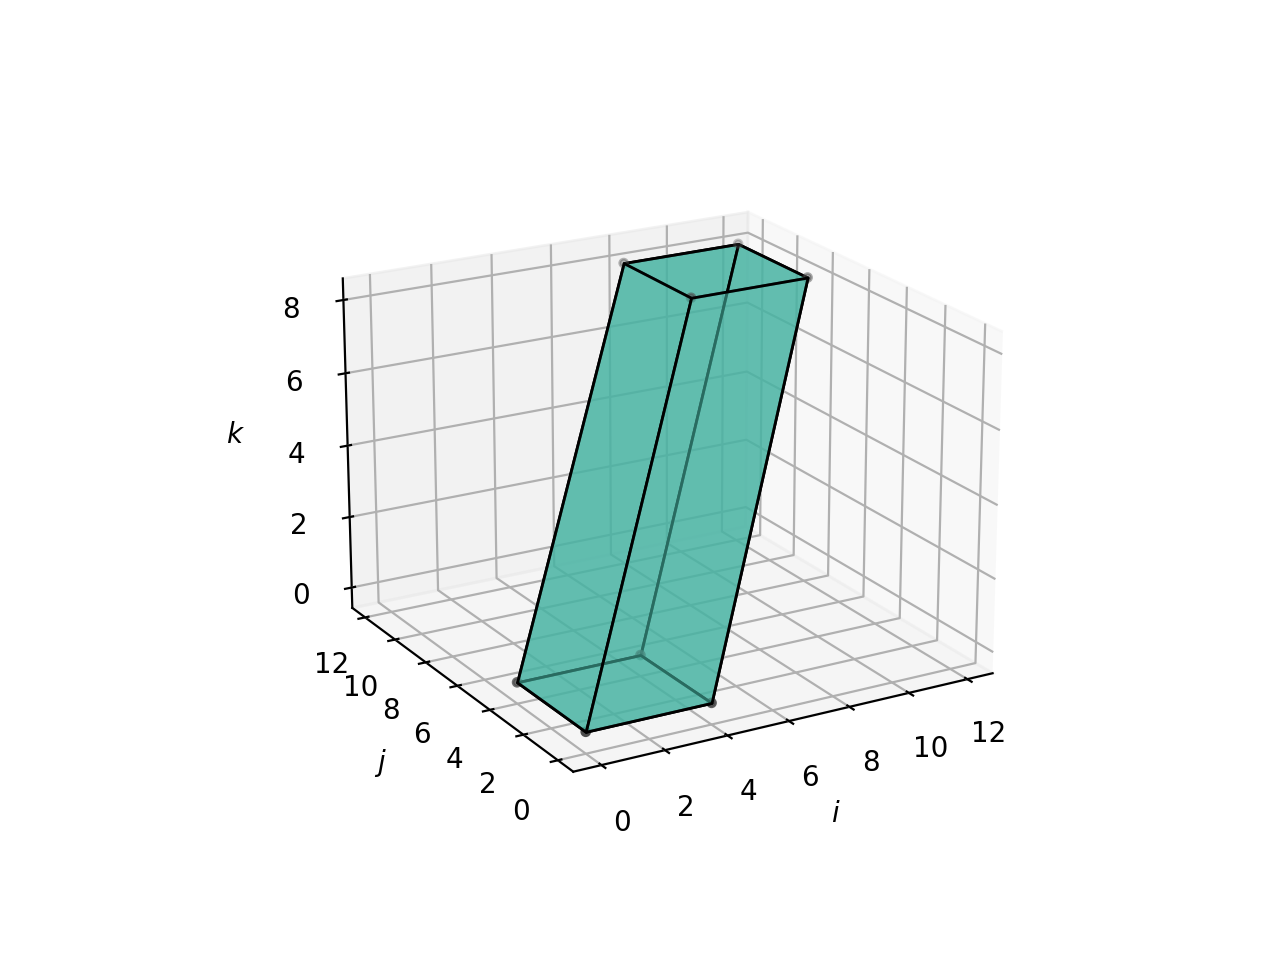

vertices:
{ [(0), (0), (0)] }
{ [(0), (4), (0)] }
{ [(4), (0), (0)] }
{ [(4), (4), (0)] }
{ [(8), (8), (8)] }
{ [(8), (12), (8)] }
{ [(12), (8), (8)] }
{ [(12), (12), (8)] }


In [2]:
polyhedron = BasicSet("{ [i, j, k] : k >= -4 + i and k >= -4 + j and 0 <= k <= 8 and k <= j and k <= i }")
num_indices = 3
num_params = 0
polyhedron_domain = Set("{ [i,j,k] : 0<=i,j<=12 and 0<=k<=8 }")
plot_3d_sets([polyhedron.intersect(polyhedron_domain)])

lattice = FaceLattice(bset=polyhedron)
vertices = [vertex.get_expr() for vertex in lattice.vertex_nodes[0][1]]
vertices.sort(key=lambda v: multi_aff_to_vec(v, num_indices, num_params)) # lexicographic order
print('vertices:')
for v in vertices:
    print(v)

## Remark 1

Given a vertex and a projection function, we can **always** construct a family of separating hyperplanes. The difficulty is choosing one in such a way that guarantees both (1) progress and (2) eventual termination.

For a projection function $f_{p}: \mathbb{Z}^{d} \rightarrow \mathbb{Z}^{d-k} $, its null space is in $\mathbb{Z}^{k}$.

For an input polyhedral set with $p$ equality constraints, let each facet at level $h$ in the face lattice be described as the $(d-p-h)$-dimensional polyhedra embedded in a $d$-dimensional space.

{ [i, j, k] : j = 0 }
{ [i, j, k] : i = 0 }


<IPython.core.display.Javascript object>


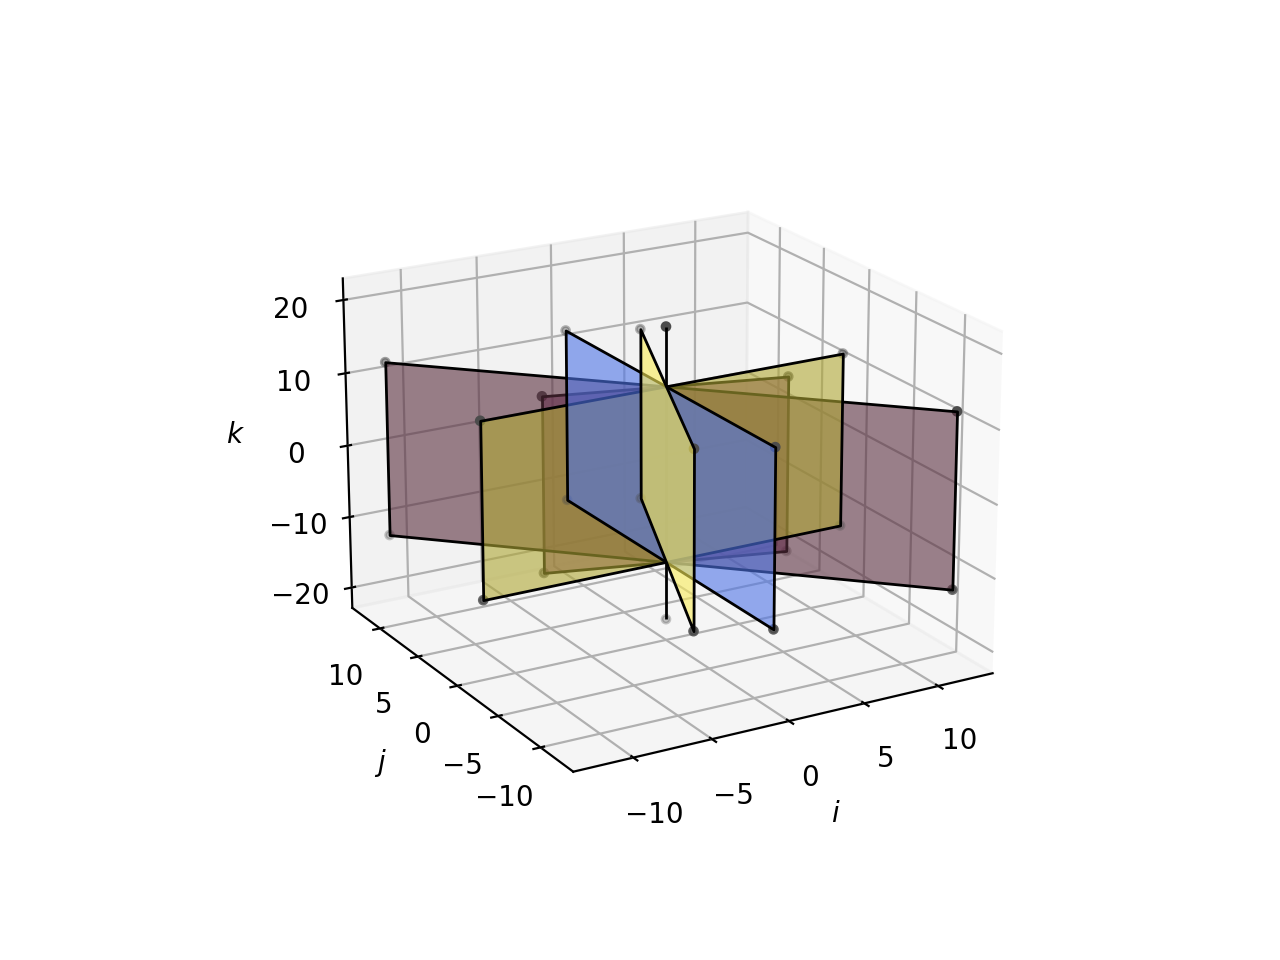

<Axes3DSubplot:xlabel='$i$', ylabel='$j$'>

In [3]:
fp = BasicMap('{[i,j,k]->[i,j]}')
ker_fp = lattice.ker(fp)

for c in ker_fp.get_constraints():
    print(c)

hyperplane = BasicSet.universe(ker_fp.get_space())
hyperplanes = []
hyperplanes.append(hyperplane.add_constraint(ker_fp.get_constraints()[0]))
hyperplanes.append(hyperplane.add_constraint(ker_fp.get_constraints()[1]))
# or any linear combination of these constraint's affine expressions, for ex:
hyperplanes.append(BasicSet('{[i,j,k] : i+j=0 }'))
hyperplanes.append(BasicSet('{[i,j,k] : 2i+7j=0 }'))
hyperplanes.append(BasicSet('{[i,j,k] : -5i+2j=0 }'))

# for plotting restrict everything to a visualization domain
#
dom = BasicSet("{ [i,j,k] : -12<=i,j,k<=12 }")
ker_fp = ker_fp.intersect(BasicSet("{ [i,j,k] : -20<=i,j,k<=20 }"))
hyperplanes = [h.intersect(dom) for h in hyperplanes]

fig = plt.figure()
plot_3d_sets(hyperplanes, fig=fig)
plot_3d_sets([ker_fp], fig=fig)

In [4]:
def create_splits(aff, lattice, node_bset, current_rank):
    
    r_aff = aff
    l_aff = r_aff.neg()
    l_aff = l_aff.set_constant_val(l_aff.get_constant_val() - 1)

    l_cut_bset = add_ineq_constraint(node_bset, l_aff)
    r_cut_bset = add_ineq_constraint(node_bset, r_aff)
    l_cut_rank = lattice.compute_rank(l_cut_bset)
    r_cut_rank = lattice.compute_rank(r_cut_bset)
    either_is_empty = l_cut_bset.is_empty() or r_cut_bset.is_empty()
    either_has_different_rank = l_cut_rank != current_rank or r_cut_rank != current_rank
    if either_is_empty or either_has_different_rank:
        return None, None
    return l_cut_bset, r_cut_bset

{ [i, j, k] -> [(j)] }
cut with aff="{ [i, j, k] -> [(j)] }" at vertex="{ [(4), (0), (0)] }" not useful

{ [i, j, k] -> [(-4 + i)] }


<IPython.core.display.Javascript object>


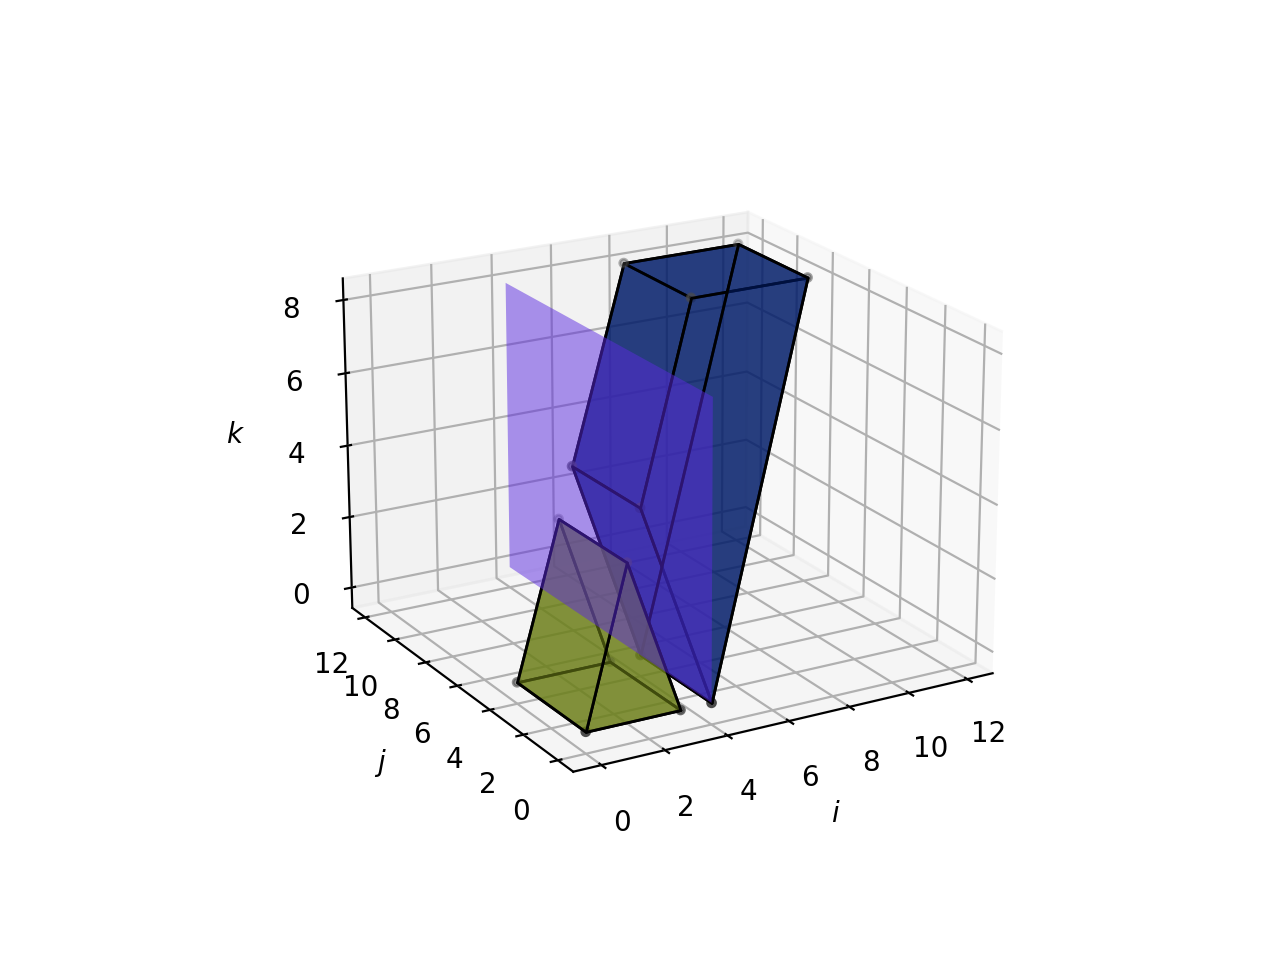


{ [i, j, k] -> [(-4 + i + j)] }


<IPython.core.display.Javascript object>


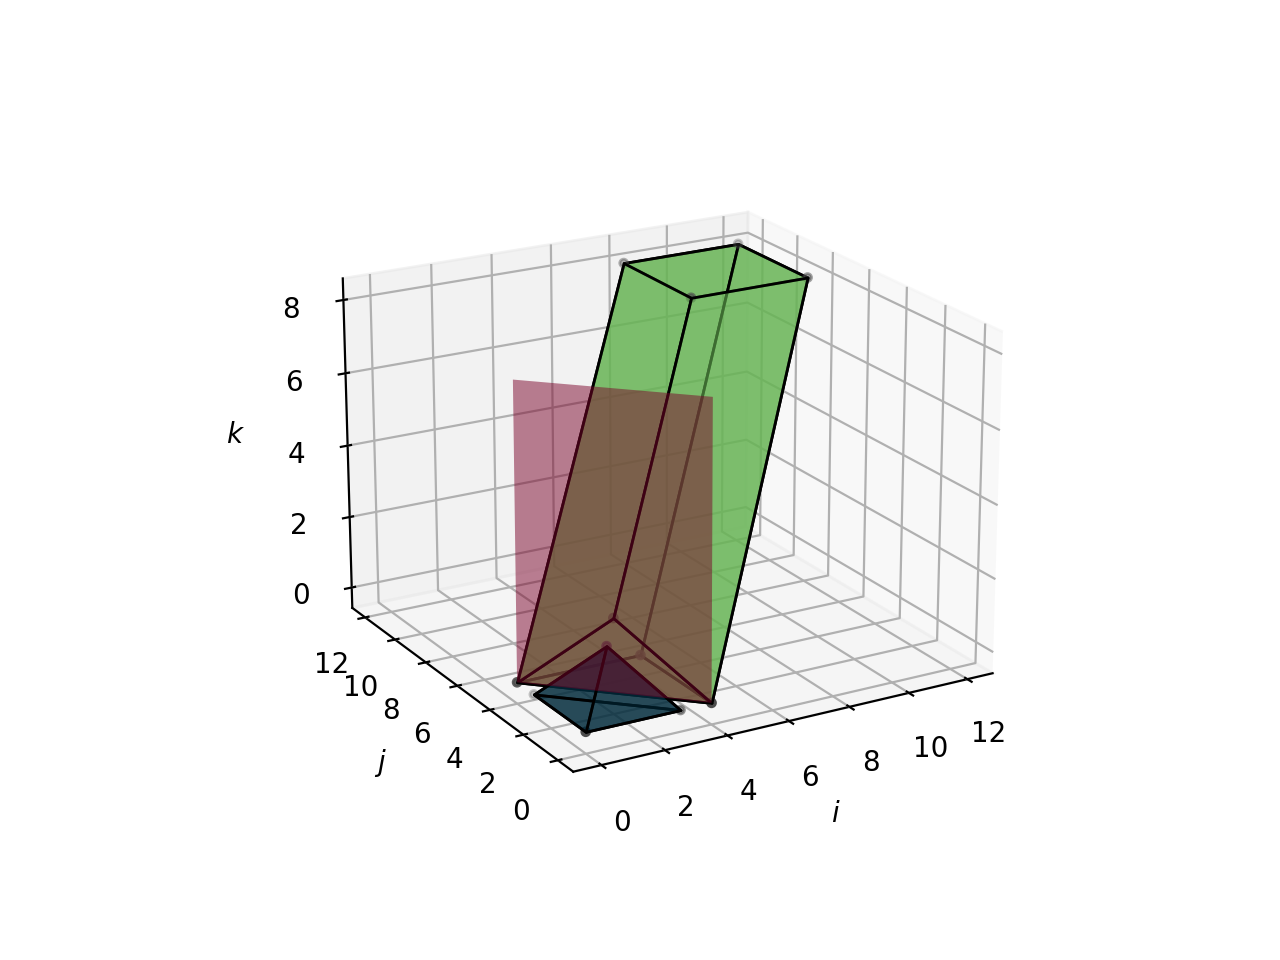


{ [i, j, k] -> [(-8 + 2i + 7j)] }
cut with aff="{ [i, j, k] -> [(-8 + 2i + 7j)] }" at vertex="{ [(4), (0), (0)] }" not useful

{ [i, j, k] -> [(20 - 5i + 2j)] }


<IPython.core.display.Javascript object>


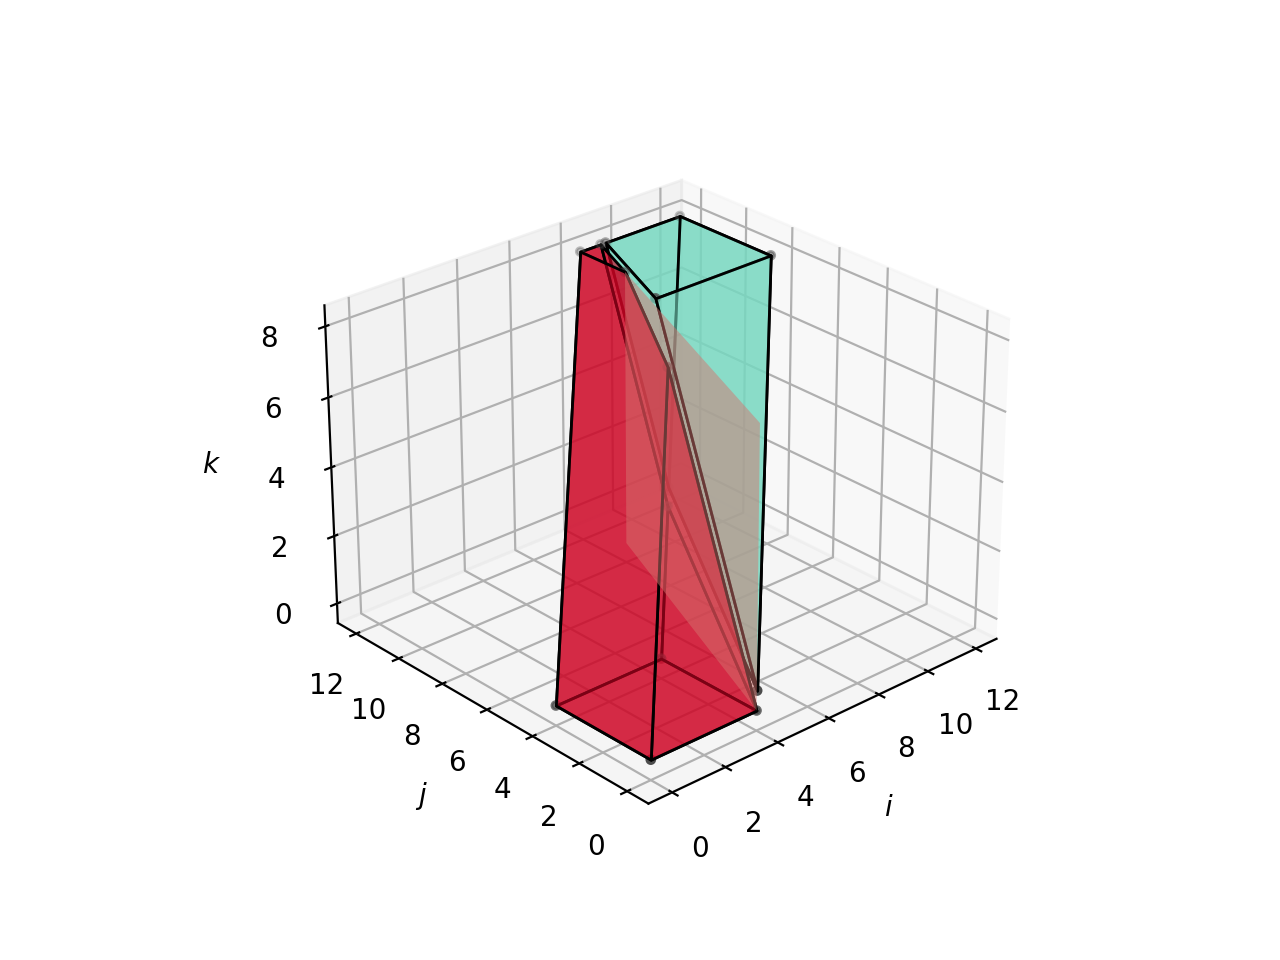

In [5]:
vertex = vertices[2]  # [4,0,0]
# translate the origin of ker_fp to a particular vertex through which to make the cut
m = build_map(ker_fp.get_space(), vertex, None, num_params, num_indices)

rank_ker_fp = lattice.compute_rank(ker_fp)
current_rank = lattice.compute_rank(polyhedron)
universe = BasicSet.universe(polyhedron.get_space())
affs = []
for h in hyperplanes:
    h_at_vertex = h.apply(m)
    equalities = [c for c in h_at_vertex.get_constraints() if c.is_equality()]
    assert len(equalities) == rank_ker_fp
    aff = equalities[0].get_aff()
    print(aff)
    l_bset, r_bset = create_splits(aff, lattice, polyhedron, current_rank)
    if not l_bset or not r_bset:
        print('cut with aff="{}" at vertex="{}" not useful'.format(aff, vertex))
        print()
        continue
    split = universe.add_constraint(Constraint.equality_from_aff(aff)).intersect(polyhedron_domain)
    plot_3d_sets([l_bset, r_bset], split=split)
    print()

## Remark 2

For nodes with rank higher than 2, **every** non-strict boundary is a weak boundary.

ex: 
fp = i,j,k -> i
ker(fp) is 2D (i.e., the jk-plane)

pseudo-proof: in 3D, any 2D slice plane that is not precisely the jk-plane has an intersection with ker(fp) of rank = 1. Ignoring constant values. there is NO 2D plane other than jk-plane whose intersection is of rank > 1.


At any given node, we can choose to do reduction decomposition and/or index set splitting. We **don't** know which one is better. We may need to explore all decompositions and all splits at all levels. At a node,
* (number of possible decompositions) = (number of weak boundaries)
* (number of possible splits) < (number of vertices)



The number of choices of reduction decompositions is driven by the number of weak boundaries present and whether or not a decomposition is feasible. We'll say decomp is feasible if $k>1$ for $f_{p}: \mathbb{Z}^{d} \rightarrow \mathbb{Z}^{d-k} $. Reduction decomposition turns a weak boundary into a strict boundary, which loosens the constraints on the reuse space.

The number of choices of splits is driven by the rank of ker(fp). Considering two problematic facets **together** force the feasible rho to be empty. 
What can we say about the null space of feasible rho?

w.r.t. splitting, want to define the split aff so that we **separate** conflicting facets.]
* Q: what makes two facets **conflict**?

Can you formulate this in such a way that "things in the kernel of X land outside"?

## Remark 3

**STRICT** boundary - facet in which **all** points in the facets contribute to the **same** answer

**WEAK** boundary - facet in which **some** (where some means at least a linear amount of) points contribute to the **same** answer

**NON** boundary - facet in which **every** point contributes to a **different** answer